<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Checklist" data-toc-modified-id="Checklist-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checklist</a></span></li></ul></div>

# Project for "Wikishop" with BERT

The online store "Wikishop" is launching a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, customers suggest their edits and comment on changes made by others. The store needs a tool that will search for toxic comments and send them for moderation.

Project point: Train a model to classify comments as positive or negative with an *F1* quality metric of at least 0.75. 


**Data Description**

The data is in the file `toxic_comments.csv`. The *text* column contains the comment text, and *toxic* is the target label.

In [ ]:
import os
print(os.getcwd())


C:\Users\datre\Desktop\Учеба\Projects\Yandex\Sentiment Analysis


In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import transformers
import datasets
import string
import nltk

RANDOM_STATE = 42

from tqdm import notebook, tqdm
from nltk import word_tokenize
from nltk.probability import FreqDist
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from wordcloud import WordCloud
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments, BertTokenizer

## Preparation

**Convert the class label column to float32 for correct loss function operations later**

In [ ]:
data = pd.read_csv('toxic_comments.csv', index_col = 'Unnamed: 0')
data = data.rename(columns={'toxic': 'labels'})
data['labels'] = data['labels'].astype('float32')
data.head()

,text,labels
0,Explanation\nWhy the edits made under my usern...,0.0
1,D'aww! He matches this background colour I'm s...,0.0
2,"Hey man, I'm really not trying to edit war. It...",0.0
3,"""\nMore\nI can't make any real suggestions on ...",0.0
4,"You, sir, are my hero. Any chance you remember...",0.0


In [ ]:
vc = data['labels'].value_counts()
vc

labels
0.0    143106
1.0     16186
Name: count, dtype: int64

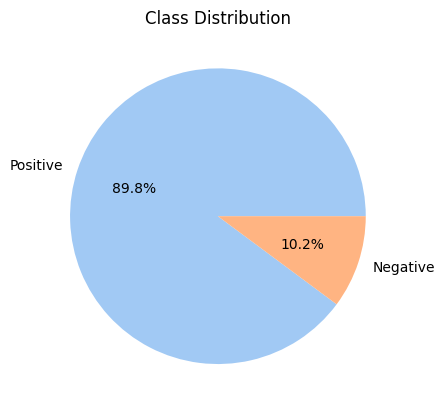

In [ ]:
colors = sns.color_palette('pastel')
plt.pie(vc, autopct='%1.1f%%', labels=['Positive', 'Negative'], colors=colors)
plt.title('Class Distribution')
plt.show()

**There is class imbalance in our data - toxic comments are much less frequent.**

**Let's do a brief frequency analysis of our dataset and visualize the result with a word cloud**

In [ ]:
data['text'][0:5] #text before cleaning

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

**Function to remove unnecessary characters from text**

In [ ]:
def remove_chars_from_text(text, chars):
    for ch in chars:
        text = text.replace('\n', ' ')
        text = text.replace(ch, '')
    return text

**Download English stopwords**

In [ ]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\datre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
special_ch = string.punctuation + '\xa0«»\t—…' + string.digits
special_ch

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\xa0«»\t—…0123456789'

**Function to prepare text for tokenization: remove special characters, lowercase, and remove stopwords**

In [ ]:
def wordcloud_prep(text):
    prep_text = remove_chars_from_text(text, chars=special_ch)
    prep_text = prep_text.lower()
    prep_text = ' '.join(word for word in prep_text.split() if word not in stopwords)
    return prep_text

In [ ]:
clear_text = data['text'].apply(wordcloud_prep)
clear_text[0:5]

0    explanation edits made username hardcore metal...
1    daww matches background colour im seemingly st...
2    hey man im really trying edit war guy constant...
3    cant make real suggestions improvement wondere...
4                  sir hero chance remember page thats
Name: text, dtype: object

**Combine texts into a single string and tokenize for further frequency analysis**

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\datre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\datre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
text_for_wordcloud = ' '.join(clear_text)
text_tokens = word_tokenize(text_for_wordcloud)
fdist = FreqDist(nltk.Text(text_tokens))

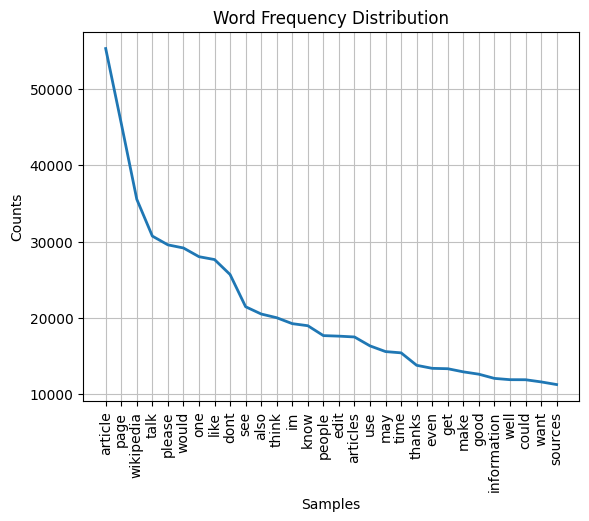

In [ ]:
plt.title('Word Frequency Distribution')
fdist.plot(30,cumulative=False);

**The chart shows that the most frequently used words are article, page, wikipedia, which is logical given the store's name. The chart also illustrates Zipf's law: word frequency decreases in proportion to 1/n of its rank.**

**For clarity, let's build a word cloud**

In [ ]:
text_raw = " ".join(text_tokens)
wordcloud = WordCloud(width=800, height=400).generate(text_raw)

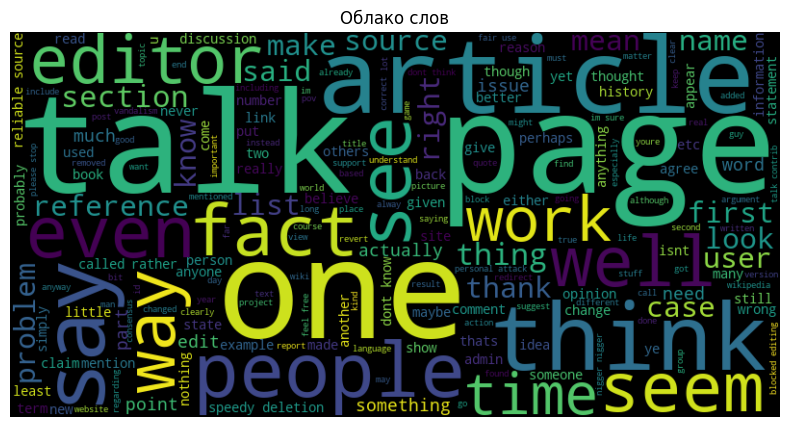

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Облако слов')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

**Let's take only 20,000 samples for faster model training.**

In [ ]:
n = 20000
data = data.sample(n)

**Split our data into train and test sets, taking class imbalance into account using stratification.**

In [ ]:
data_train, data_test = train_test_split(data, 
                                         test_size=0.2, 
                                         random_state=RANDOM_STATE, 
                                         stratify=data['labels'])
data_train.shape, data_test.shape

((16000, 2), (4000, 2))

In [ ]:
data_train['labels'].value_counts(normalize=True)

labels
0.0    0.901375
1.0    0.098625
Name: proportion, dtype: float64

In [ ]:
data_test['labels'].value_counts(normalize=True)

labels
0.0    0.9015
1.0    0.0985
Name: proportion, dtype: float64

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**We will use the lighter BERT base model (uncased), as others train too slowly on CPU.**

In [ ]:
model_id='bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_id)

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained(model_id, 
                                                                   num_labels=1,
                                                                   hidden_dropout_prob=0.3,
                                                                   attention_probs_dropout_prob=0.3)
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<!-- removed colored block -->

**Tokenize the text and convert it to tensor format for further training.**

In [ ]:
def preprocess_function(data):
   return tokenizer(data['text'], padding=True, truncation=True, add_special_tokens = True, max_length=128)
data_train = datasets.Dataset.from_pandas(data_train)
data_test = datasets.Dataset.from_pandas(data_test)
tokenized_train = data_train.map(preprocess_function, batched=True)
tokenized_test = data_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.remove_columns(['text'])
tokenized_test = tokenized_test.remove_columns(['text']) 

tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

## Training

**Split datasets into batches using PyTorch DataLoader**

In [ ]:
BATCH_SIZE = 20

train_loader = DataLoader(tokenized_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=BATCH_SIZE, shuffle=True)

**Since our task is binary classification, we use binary cross-entropy as the loss function, and also pass class weights.**

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(data_train['labels']), y=data_train['labels'])
class_weights

array([0.55470808, 5.06970849])

**Use Mixed Precision Training to speed up computations**

In [ ]:
torch.cuda.is_available()


True

In [ ]:
scaler = torch.amp.GradScaler('cuda')

**Set L2 regularization via the optimizer's weight_decay argument, and set learning_rate**

In [ ]:
weights = torch.tensor(class_weights, dtype=torch.float)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.04)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=weights[1])

In [ ]:
EPOCHS = 7
LOG_EVERY = 10

train_losses_epoch = [] 
test_losses_epoch = [] 
test_accuracy = []
test_f1 = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')

    model.train()
    total_loss_train = 0
    progress_bar = tqdm(train_loader, desc='Training')

    for step, batch in enumerate(progress_bar): 
        optimizer.zero_grad()
        
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)
            loss_train = loss_func(logits, labels)
        
        scaler.scale(loss_train).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss_train += loss_train.item()
        
        
        if (step + 1) % LOG_EVERY == 0:
            progress_bar.set_postfix({'Loss': total_loss_train / (step + 1)})

    avg_train_loss = total_loss_train / len(train_loader)
    train_losses_epoch.append(avg_train_loss)

    
    model.eval()
    total_test_loss = 0
    predictions = [] 
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Test'):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

        
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)
            loss_test = loss_func(logits, labels)
                
            total_test_loss += loss_test.item()

            probs = torch.sigmoid(logits)  
            preds = (probs > 0.5).float() 
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses_epoch.append(avg_test_loss)
 
    test_f1.append(f1_score(true_labels, predictions))
    test_accuracy.append(accuracy_score(true_labels, predictions))

    print(f'Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}, Test f1 = {f1_score(true_labels, predictions):.4f}, Test Accuracy = {accuracy_score(true_labels, predictions):.4f}')

Epoch 1/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:50<00:00,  1.18it/s]


Train Loss = 0.4243, Test Loss = 0.3208, Test f1 = 0.7332, Test Accuracy = 0.9365
Epoch 2/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:54<00:00,  1.15it/s]


Train Loss = 0.2364, Test Loss = 0.3312, Test f1 = 0.7314, Test Accuracy = 0.9343
Epoch 3/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:43<00:00,  1.22it/s]


Train Loss = 0.1948, Test Loss = 0.3176, Test f1 = 0.7963, Test Accuracy = 0.9555
Epoch 4/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [03:02<00:00,  1.10it/s]


Train Loss = 0.1660, Test Loss = 0.3366, Test f1 = 0.7443, Test Accuracy = 0.9385
Epoch 5/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:58<00:00,  1.12it/s]


Train Loss = 0.1368, Test Loss = 0.3729, Test f1 = 0.7933, Test Accuracy = 0.9565
Epoch 6/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:55<00:00,  1.14it/s]


Train Loss = 0.1246, Test Loss = 0.3729, Test f1 = 0.7541, Test Accuracy = 0.9437
Epoch 7/7


Test: 100%|██████████████████████████████████████████████████████████████████████████| 200/200 [02:52<00:00,  1.16it/s]

Train Loss = 0.1008, Test Loss = 0.4190, Test f1 = 0.7746, Test Accuracy = 0.9503


**For such a small data sample, after 7 epochs we obtained a good result: f1 = 0.81**

**Visualize quality metrics and loss values by epoch**

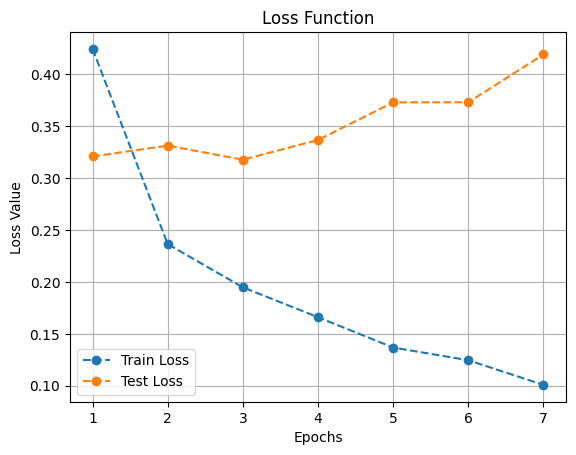

In [ ]:
epochs = range(1, EPOCHS + 1)

plt.plot(epochs, train_losses_epoch, label='Train Loss', marker='o', linestyle='--')
plt.plot(epochs, test_losses_epoch, label='Test Loss', marker='o', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Loss Function')
plt.legend()
plt.grid(True)
plt.show()

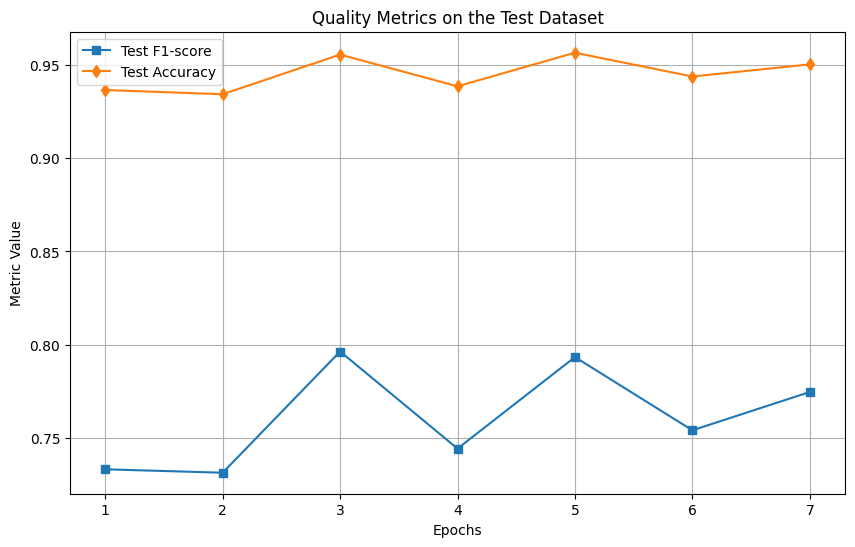

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, test_f1, label='Test F1-score', marker='s')
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='d')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Quality Metrics on the Test Dataset')
plt.legend()
plt.grid(True)
plt.show()

**Since the loss function on the test set first decreases and then increases, our model cannot capture all patterns; BCEWithLogitsLoss (cross-entropy) penalizes the model for confident errors, even if F1-score grows**

**Let's write a function to predict text sentiment and test it on examples**

In [ ]:
def predict_sentiment(model, text, tokenizer):
    model.eval()
    tokens = tokenizer(text, 
                       padding=True, 
                       truncation=True, 
                       add_special_tokens = True, 
                       max_length=128,
                       return_tensors='pt')
    
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = output.logits.squeeze(-1)
    prob = torch.sigmoid(logits).item()
    predicted_class = 'toxic' if prob > 0.5 else 'not_toxic'
    return {'text': text, 'probability': prob, 'predicted_class': predicted_class}

In [ ]:
example_texts = ['OMG i like those <3', 'I WILL KILL YOUR FAMILY', 'Ahahaha, idc buddy, go fuck yourself']
for text in example_texts:
    prediction = predict_sentiment(model, text, tokenizer)
    print(f"Text: {prediction['text']}")
    print(f"Predicted Sentiment: {prediction['predicted_class']} (Probability: {prediction['probability']:.4f})")

Text: OMG i like those <3
Predicted Sentiment: not_toxic (Probability: 0.0008)
Text: I WILL KILL YOUR FAMILY
Predicted Sentiment: toxic (Probability: 0.9992)
Text: Ahahaha, idc buddy, go fuck yourself
Predicted Sentiment: toxic (Probability: 0.9994)


**On manually entered examples, the model gave correct answers**

## Conclusions

**In this work, we developed a model based on HuggingFace BERT for processing messages in the online store community and determining their sentiment (toxic/non-toxic).
To achieve this goal, the following steps were performed:**

* Built a word cloud and frequency distribution
* Tokenized data using BertTokenizer
* Prepared the dataset for PyTorch using Datasets functionality
* Used 20,000 samples for training/testing
* Implemented a model based on transformers.BertForSequenceClassification and 'bert-base-uncased'
* Used AdamW for gradient descent optimization, and BCEWithLogitsLoss as the loss function, taking class imbalance into account
* Computations were accelerated on GPU
* The resulting model achieved an f1 metric of ~0.82
* Demonstrated the model's performance on examples